In [268]:
import os
import datetime
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Helper Functions

In [269]:
#Clean the currency column to make it a float
#The Revenue column is a string so we need to convert to floatdef clean_currency(x):
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('€', '').replace(',', ''))
    return(x)

# Data Preperation

In [270]:
df = pd.read_csv("data/20200701.csv")

In [271]:
df.head()

,Date,Actuals Rev
0,2020-07-01,"€599,023"
1,2020-07-02,"€626,646"
2,2020-07-03,"€625,228"
3,2020-07-04,"€470,988"
4,2020-07-05,"€537,747"


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         27 non-null     object
 1   Actuals Rev  27 non-null     object
dtypes: object(2)
memory usage: 560.0+ bytes


In [273]:
#Convert Date column to timestamp
df.set_index('Date',inplace=True)

In [274]:
df.index = pd.to_datetime(df.index)

In [275]:
int(time.mktime(df.index[1].timetuple()))

1593648000

In [276]:
#Convert timestamp to int for TensorFlow Dataset
def timestamp_to_int(timestamp):
    print(timestamp)
    int_time = int(time.mktime(df.index[timestamp].timetuple()))
    return int_time

In [277]:
def int_to_timestamp(timestamp):
    #datetime.datetime.fromtimestamp(1593648000)
    return datetime.datetime.fromtimestamp(timestamp)

In [278]:
time_in_int = []
for i in range(len(df.index)):
    int_t = int(time.mktime(df.index[i].timetuple()))
    time_in_int.append(int_t)

In [279]:
df["int_time"] = time_in_int
df.head()

,Actuals Rev,int_time
Date,,
2020-07-01,"€599,023",1593561600
2020-07-02,"€626,646",1593648000
2020-07-03,"€625,228",1593734400
2020-07-04,"€470,988",1593820800
2020-07-05,"€537,747",1593907200


In [280]:
df.set_index('int_time',inplace=True)

In [281]:
#Convert Revenue column to Float
df["Actuals Rev"] = df['Actuals Rev'].apply(clean_currency).astype('float')

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 1593561600 to 1595808000
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Actuals Rev  27 non-null     float64
dtypes: float64(1)
memory usage: 432.0 bytes


# Data Visualization

<AxesSubplot:xlabel='int_time', ylabel='Actuals Rev'>

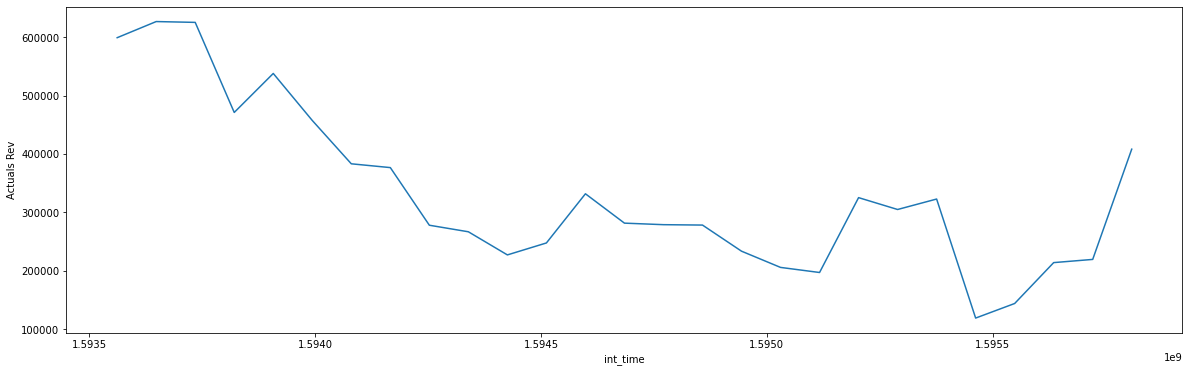

In [283]:
fig_dims = (20,6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("Date",fontsize=10)
plt.xticks(fontsize=10)
sns.lineplot(x=df.index,y="Actuals Rev",data=df)

# Tensorflow Model

In [284]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Preparing Training and Test Data

In [285]:
train_data = df[0:17]
test_data = df[17:]
val_data = df[17:]#Change this to a different dataset in the future

## Scaling the data

In [286]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [287]:
stnd_scaler = StandardScaler()

In [288]:
scaled_train = stnd_scaler.fit_transform(train_data)
scaled_test = stnd_scaler.fit_transform(test_data)
scaled_val = stnd_scaler.fit_transform(val_data)

## Create the tensorflow dataset from timeseries

In [289]:
tf_data = tf.keras.preprocessing.timeseries_dataset_from_array(

      data = scaled_train,
      targets=None,
      sequence_length = 10,
      sequence_stride = 1,
      shuffle = True,
      batch_size = 2
)

## Create Windowing

In [290]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [291]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Actuals Rev'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Actuals Rev']

In [292]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Actuals Rev'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Actuals Rev']

In [293]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [294]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(scaled_train[:w2.total_window_size]),
                           np.array(scaled_train[7:7+w2.total_window_size]),
                           np.array(scaled_train[10:10+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
labels shape: (3, 1, 1)


## Plotting the data

In [295]:
w2.example = example_inputs, example_labels

In [296]:
def plot(self, model=None, plot_col='Actuals Rev', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

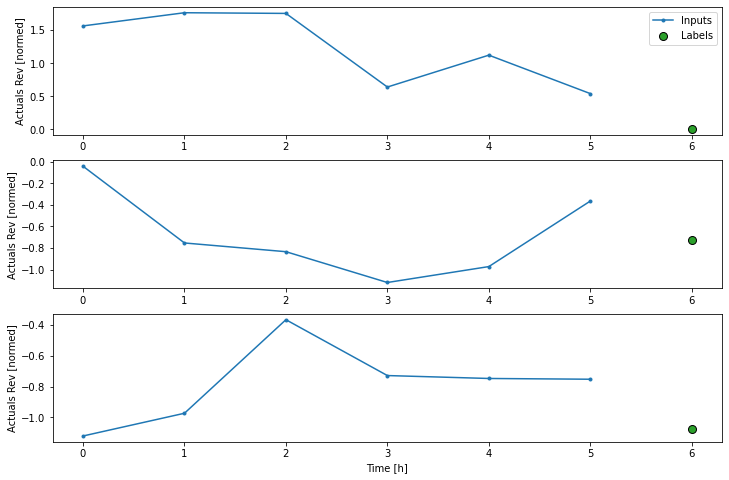

In [297]:
w2.plot()

## Create a dataset using Tensorflow

In [298]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [299]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [300]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [301]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (11, 6, 1)
Labels shape (batch, time, features): (11, 1, 1)


In [302]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Actuals Rev'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Actuals Rev']

In [303]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 1, 1)
Labels shape (batch, time, features): (16, 1, 1)


## Baseline Model

In [304]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [305]:
baseline = Baseline(label_index=column_indices["Actuals Rev"]) # changed from label_index=column_indices['Actuals Rev'] to df["Actual Revs"]
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 1ms/step - loss: 11113241600.0000 - mean_absolute_error: 74254.7812


In [306]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Actuals Rev'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Actuals Rev']

In [307]:
#print('Input shape:', wide_window.example[0].shape)
#print('Output shape:', baseline(wide_window.example[0]).shape)

## Linear Model

In [308]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [309]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (16, 1, 1)
Output shape: (16, 1, 1)


In [390]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [391]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
1/1 [==============================] - 0s 392ms/step - loss: 57384824832.0000 - mean_absolute_error: 222838.5625 - val_loss: 35137495040.0000 - val_mean_absolute_error: 165615.7500
Epoch 2/100
1/1 [==============================] - 0s 222ms/step - loss: 57191882752.0000 - mean_absolute_error: 222446.9844 - val_loss: 35063545856.0000 - val_mean_absolute_error: 165459.6094
Epoch 3/100
1/1 [==============================] - 0s 224ms/step - loss: 56999292928.0000 - mean_absolute_error: 222055.4219 - val_loss: 34989723648.0000 - val_mean_absolute_error: 165303.5000
Epoch 4/100
1/1 [==============================] - 0s 201ms/step - loss: 56807059456.0000 - mean_absolute_error: 221663.9062 - val_loss: 34916024320.0000 - val_mean_absolute_error: 165147.4062
Epoch 5/100
1/1 [==============================] - 0s 218ms/step - loss: 56615198720.0000 - mean_absolute_error: 221272.4375 - val_loss: 34842439680.0000 - val_mean_absolute_error: 164991.3125
Epoch 6/100
1/1 [==================

## Dense Model

In [392]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
1/1 [==============================] - 0s 474ms/step - loss: 177093083136.0000 - mean_absolute_error: 396703.6875 - val_loss: 75147436032.0000 - val_mean_absolute_error: 258835.0000
Epoch 2/100
1/1 [==============================] - 0s 257ms/step - loss: 165461393408.0000 - mean_absolute_error: 383315.5625 - val_loss: 71134740480.0000 - val_mean_absolute_error: 251142.4375
Epoch 3/100
1/1 [==============================] - 0s 292ms/step - loss: 154370588672.0000 - mean_absolute_error: 370095.0625 - val_loss: 67365613568.0000 - val_mean_absolute_error: 243679.0781
Epoch 4/100
1/1 [==============================] - 0s 222ms/step - loss: 143985508352.0000 - mean_absolute_error: 357268.3750 - val_loss: 63860957184.0000 - val_mean_absolute_error: 236511.7812
Epoch 5/100
1/1 [==============================] - 0s 293ms/step - loss: 134360367104.0000 - mean_absolute_error: 344950.5312 - val_loss: 60482920448.0000 - val_mean_absolute_error: 229374.4688
Epoch 6/100
1/1 [=============

In [393]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Actuals Rev'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Actuals Rev']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

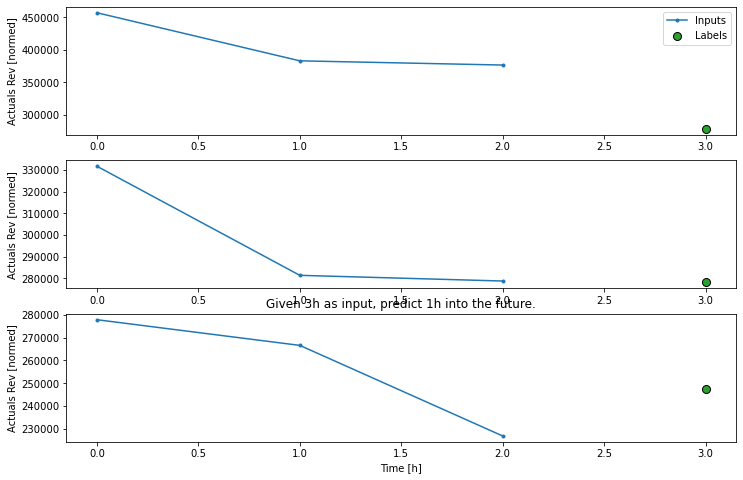

In [394]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [395]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [396]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (14, 3, 1)
Output shape: (14, 1, 1)


In [397]:
history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/100
1/1 [==============================] - 0s 456ms/step - loss: 23661084672.0000 - mean_absolute_error: 143178.9844 - val_loss: 30366576640.0000 - val_mean_absolute_error: 138825.1719
Epoch 2/100
1/1 [==============================] - 0s 261ms/step - loss: 18629683200.0000 - mean_absolute_error: 125067.8203 - val_loss: 28229310464.0000 - val_mean_absolute_error: 134139.9531
Epoch 3/100
1/1 [==============================] - 0s 292ms/step - loss: 14246393856.0000 - mean_absolute_error: 106708.0781 - val_loss: 26335950848.0000 - val_mean_absolute_error: 131029.1094
Epoch 4/100
1/1 [==============================] - 0s 275ms/step - loss: 10619578368.0000 - mean_absolute_error: 88825.8594 - val_loss: 24697223168.0000 - val_mean_absolute_error: 127879.7891
Epoch 5/100
1/1 [==============================] - 0s 287ms/step - loss: 7759201792.0000 - mean_absolute_error: 75541.2500 - val_loss: 23304517632.0000 - val_mean_absolute_error: 124807.7891
Epoch 6/100
1/1 [=====================

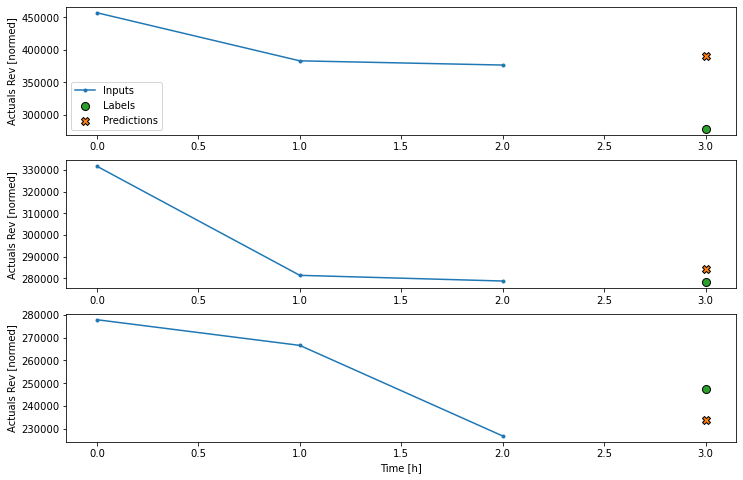

In [398]:
conv_window.plot(multi_step_dense)

## Convoluational NN

In [387]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=512,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [388]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (14, 3, 1)
Output shape: (14, 1, 1)


In [389]:
history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/100
1/1 [==============================] - 1s 522ms/step - loss: 107356856320.0000 - mean_absolute_error: 315188.3438 - val_loss: 46960607232.0000 - val_mean_absolute_error: 190767.7969
Epoch 2/100
1/1 [==============================] - 0s 218ms/step - loss: 60914589696.0000 - mean_absolute_error: 237104.0312 - val_loss: 33423849472.0000 - val_mean_absolute_error: 152237.0781
Epoch 3/100
1/1 [==============================] - 0s 291ms/step - loss: 30371063808.0000 - mean_absolute_error: 166049.3281 - val_loss: 24330561536.0000 - val_mean_absolute_error: 132261.5312
Epoch 4/100
1/1 [==============================] - 0s 213ms/step - loss: 12121873408.0000 - mean_absolute_error: 100695.5625 - val_loss: 18790172672.0000 - val_mean_absolute_error: 120696.3594
Epoch 5/100
1/1 [==============================] - 0s 266ms/step - loss: 3609556736.0000 - mean_absolute_error: 45700.7930 - val_loss: 16346598400.0000 - val_mean_absolute_error: 110358.2891
Epoch 6/100
1/1 [===================

In [363]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Actuals Rev'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Actuals Rev']

In [323]:
#wide_conv_window.plot(conv_model)

## Recurrent NN

In [326]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [327]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20


UnboundLocalError: local variable 'logs' referenced before assignment

In [ ]:
wide_window

## Performance

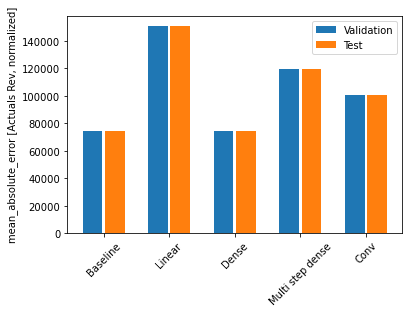

In [399]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = conv_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Actuals Rev, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [400]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 74254.7812
Linear      : 150655.8125
Dense       : 74741.0547
Multi step dense: 119855.2344
Conv        : 100701.2500
